In [108]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
    Created on Thu Jul 18 2025
    
    @author: Yaning
"""

import os
import torch
import pyro
from pyro.optim import Adam
import pyro.distributions as dist
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
import pickle
from pyro.infer import SVI, Trace_ELBO
import re
import pandas as pd

Run the script on CPU or GPU depending on the system settings.

In [109]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Import datasets (cafe gamble, future cueing and buhui dataset)

In [ ]:
with open('/home/yaning/Documents/Discounting/results/array_future.pkl', 'rb') as f:
    data = pickle.load(f)

data = torch.tensor(data)
data = data.to(device)

In [114]:
data = data[0]

Model

In [115]:
def model(data):
    num_params = 3
    num_agents = data.shape[0]
    num_trials = data.shape[1]
    # define hyper priors over model parameters
    # prior over sigma of a Gaussian is a Gamma distribution
    a = pyro.param('a', torch.ones(num_params, device=device), constraint=dist.constraints.positive)
    lam = pyro.param('lam', torch.ones(num_params, device=device), constraint=dist.constraints.positive)
    tau = pyro.sample('tau', dist.Gamma(a, a/lam).to_event(1)) # mean = a / (a/lam) = lam

    sig = pyro.deterministic('sig', 1/torch.sqrt(tau)) # Gauss sigma

    # each model parameter has a hyperprior defining group level mean
    # in the form of a Normal distribution
    m = pyro.param('m', torch.zeros(num_params, device=device))
    s = pyro.param('s', torch.ones(num_params, device=device), constraint=dist.constraints.positive)
    mu = pyro.sample('mu', dist.Normal(m, s*sig).to_event(1)) # Gauss mu, wieso s*sig?

    # in order to implement groups, where each subject is independent of the others, pyro uses so-called plates.
    # you embed what should be done for each subject into the "with pyro.plate" context
    # the plate vectorizes subjects and adds an additional dimension onto all arrays/tensors
    # i.e. p1 below will have the length num_agents
    with pyro.plate('ag_idx', num_agents):
        # draw parameters from Normal and transform (for numeric trick reasons)
        # base_dist = dist.Normal(0., 1.).expand_by([num_params]).to_event(1)
        base_dist = dist.Normal(torch.zeros(num_params, device=device), torch.ones(num_params, device=device)).to_event(1)
        # Transform via the pointwise affine mapping y = loc + scale*x (-> Neal's funnel)
        transform = dist.transforms.AffineTransform(mu, sig)

        locs = pyro.sample('locs', dist.TransformedDistribution(base_dist, [transform]))
        # print(locs.shape)


    with pyro.plate('data', num_agents*num_trials):
        sigma_rate = torch.exp(locs[:,0]).unsqueeze(-1).expand(-1, num_trials)
        # exp_a = torch.exp(locs[:,1]).unsqueeze(-1).expand(-1, num_trials)
        exp_b = torch.exp(locs[:,1]).unsqueeze(-1).expand(-1, num_trials)
        beta = torch.exp(locs[:,2]).unsqueeze(-1).expand(-1, num_trials)

        sigma_combine = sigma_rate/(1+exp_b*torch.exp(-data[:,:,2]))

        e_mean = (data[:,:,3])/(sigma_combine**2 + 1)
        sum = e_mean + torch.tensor(20., device=device)

        softmax_args = torch.stack([beta*e_mean/sum, beta*torch.tensor(20., device=device)/sum])
        p = torch.softmax(softmax_args, dim = 0)[0]

    pyro.sample("obs", dist.Bernoulli(probs = p).to_event(2), obs=data[:,:,4])

    # return locs

Guide

In [116]:
def guide(data):
    num_params = 3
    num_agents = data.shape[0]
    # biject_to(constraint) looks up a bijective Transform from constraints.real 
    # to the given constraint. The returned transform is guaranteed to have 
    # .bijective = True and should implement .log_abs_det_jacobian().
    trns = torch.distributions.biject_to(dist.constraints.positive)

    # define mean vector and covariance matrix of multivariate normal
    m_hyp = pyro.param('m_hyp', torch.zeros(2*num_params, device=data.device))
    st_hyp = pyro.param('scale_tril_hyp',
                    torch.eye(2*num_params, device=data.device),
                    constraint=dist.constraints.lower_cholesky)

    # set hyperprior to be multivariate normal
    # scale_tril (Tensor) – lower-triangular factor of covariance, with positive-valued diagonal
    hyp = pyro.sample('hyp',
                    dist.MultivariateNormal(m_hyp, scale_tril=st_hyp),
                    infer={'is_auxiliary': True})

    # mu & tau unconstrained
    unc_mu = hyp[..., :num_params]
    unc_tau = hyp[..., num_params:]

    # constrained tau, shape num_params, or num_particles, 1, num_params
    c_tau = trns(unc_tau)

    # ld = log_density
    # log_abs_det_jacobian(x, y) computes derivative |dy/dx|
    ld_tau = -trns.inv.log_abs_det_jacobian(c_tau, unc_tau)
    
    # sum_rightmost(x, dim)
    # sum out ``dim`` many rightmost dimensions of a given tensor.
    # ld_tau.shape is num_params, or num_particles, 1, num_params before sum_rightmost
    ld_tau = dist.util.sum_rightmost(ld_tau, ld_tau.dim() - c_tau.dim() + 1)

    # some numerics tricks
    mu = pyro.sample("mu", dist.Delta(unc_mu, event_dim=1))
    # c_tau shape: num_params, or num_particles, 1, num_params
    # ld_tau shape: [] or num_particles, 1,
    tau = pyro.sample("tau", dist.Delta(c_tau, log_density=ld_tau, event_dim=1))

    m_locs = pyro.param('m_locs', torch.zeros(num_agents, num_params, device=data.device))
    st_locs = pyro.param('scale_tril_locs',
                    torch.eye(num_params, device=data.device).repeat(num_agents, 1, 1),
                    constraint=dist.constraints.lower_cholesky)
    
    with pyro.plate('ag_idx', num_agents):
        locs = pyro.sample("locs", dist.MultivariateNormal(m_locs, scale_tril=st_locs))

    return {'tau': tau, 'mu': mu, 'locs': locs, 'm_locs': m_locs, 'st_locs': st_locs}

Run the inference

Mean ELBO 969.30: 100%|██████████████████████████████████████████████████████████████| 5000/5000 [00:30<00:00, 162.15it/s]


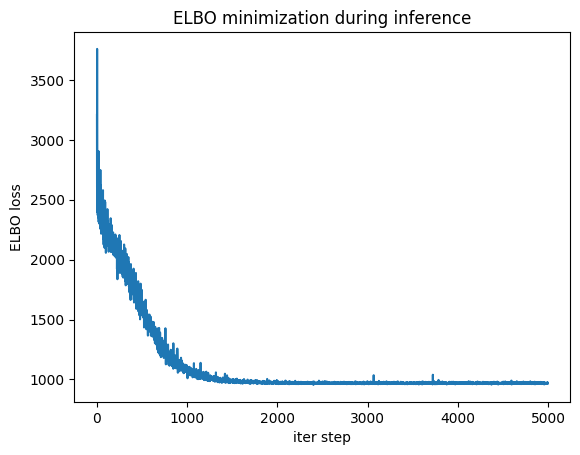

In [117]:
# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
# the step was 2000
n_steps = 2 if smoke_test else 5000

# assert pyro.__version__.startswith('1.8.6')

# clear the param store in case we're in a REPL
pyro.clear_param_store()# setup the optimizer
# the learning rate was 0.0005 , "betas": (0.90, 0.999)
# tried "n_par":15 in adam params but it does not have this argument
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)
# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
# svi = SVI(model_gamma, guide_gamma, optimizer, loss=Trace_ELBO())

loss = []
pbar = tqdm(range(n_steps), position = 0)
# do gradient steps
for step in pbar:
    loss.append(torch.tensor(svi.step(data)))
    pbar.set_description("Mean ELBO %6.2f" % torch.tensor(loss[-20:]).mean())
    # for name, value in pyro.get_param_store().items():
    #     print(name, pyro.param(name))
    if torch.isnan(loss[-1]):
	    break

plt.figure()
plt.plot(loss)
plt.xlabel("iter step")
plt.ylabel("ELBO loss")
plt.title("ELBO minimization during inference")
plt.show()

In [50]:
for i in loss:
    print(i.numpy())

3524.1055
3459.9807
3787.0974
3886.427
3806.434
3252.0393
3579.7454
3444.9465
3287.089
3618.1143
3566.0144
3389.3267
3562.3557
3767.9458
3433.461
3301.4053
3176.116
3829.0017
3337.3682
3487.5374
3595.183
3216.8809
3684.9963
3366.0952
3334.6294
3378.1772
3635.0454
3418.3699
3369.3171
3224.6611
3152.546
3126.3474
3524.9832
3581.1216
3354.9832
3399.3987
3388.049
3403.8767
3277.0898
3326.763
3168.0361
3697.6292
3516.6055
3343.8818
3162.933
3281.4497
3377.4197
3232.3174
3113.323
3367.141
3271.3003
3081.0156
3186.1494
3385.441
3278.5115
3139.924
3330.6248
3353.0227
3106.8604
3277.7961
3166.5466
3198.173
2980.341
3355.2576
3393.169
3875.8105
3533.4187
3197.7075
3162.5193
3285.162
3485.185
3091.016
2988.5334
3212.9841
3053.8972
3351.6797
3279.273
3138.9985
3151.7996
3075.4392
3100.5715
3498.95
2983.8782
2910.2744
3227.627
3454.9019
3184.9065
3116.2651
3215.1897
3169.1785
3035.5881
3191.747
3234.442
3085.899
3224.0159
3007.5977
3269.2568
3018.1892
2999.5066
2990.5508
2895.9128
3094.9617
3169.02

Get the dictionary containing inferred parameters

In [118]:
pos_dict = {}
for name, value in pyro.get_param_store().items():
    pos_dict[name] = value

# change the dictionary to numpy instead of tensor
# because somehow the tensor cannot be save with pickle
numpy_dict = {key: value.detach().cpu().numpy() for key, value in pos_dict.items()}

Mean values of the inferred parameters

In [119]:
numpy_dict["m"]

array([0.06430974, 2.534872  , 3.022464  ], dtype=float32)

In [31]:
# save the dictionary
with open('/home/yaning/Documents/Discounting/paper/results/three_param_gamble.pkl', 'wb') as f:
    pickle.dump(numpy_dict, f)

Use guide to get the posterior samples

In [120]:
sample_num = 1000
tau = []
mu = []
locs = []
for i in range(sample_num):
    tau.append(guide(data)['tau'].detach().cpu().numpy())
    mu.append(guide(data)['mu'].detach().cpu().numpy())
    locs.append(guide(data)['locs'].detach().cpu().numpy())

In [121]:
tau = np.array(tau)
mu = np.array(mu)
locs = np.array(locs)

In [122]:
sample_dict = {}
sample_dict['tau'] = tau
sample_dict['mu'] = mu
sample_dict['locs'] = locs

In [123]:
# save the dictionary
with open('/home/yaning/Documents/Discounting/paper/results/no_future_samples.pkl', 'wb') as f:
    pickle.dump(sample_dict, f)

In [124]:
df = pd.DataFrame(mu, columns=['sigma_rate', 'exp_b', 'beta'])

In [125]:
df

,sigma_rate,exp_b,beta
0,-0.032918,2.394701,2.986546
1,-0.050291,2.548670,3.014872
2,0.039348,2.372271,2.943858
3,0.010487,2.440426,2.863603
4,0.051752,2.424636,2.808123
...,...,...,...
995,0.034144,2.547494,2.911866
996,0.015090,2.326818,2.940202
997,-0.050465,2.283103,3.017241
998,0.055808,2.512671,3.030780


In [126]:
df.to_csv("/home/yaning/Documents/Discounting/paper/results/no_future_sample.csv", index=False)